In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import ExtraTreesClassifier as ExTC
#from pprint import pprint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
R2 = pd.read_csv('./surrogate_performance/R^2.csv', index_col=0)
features = pd.read_csv('./features/benchmark.csv', index_col=0)

In [3]:
cv_max = pd.read_csv('./surrogate_performance/benchmarkCV-score-max.csv', index_col=0)
cv_mean = pd.read_csv('./surrogate_performance/benchmarkCV-score-mean.csv', index_col=0)

In [4]:
# Drop NANs
features.dropna(axis = 1, inplace=True)

In [5]:
# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

In [6]:
# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

In [7]:
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

In [8]:
# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]

In [9]:
# Doing the same for cv_max and cv_mean

cv_max = cv_max.loc[features_available_for]
cv_mean = cv_mean.loc[features_available_for]
cv_mean_best = cv_mean.idxmax(axis=1)
cv_max_best = cv_max.idxmax(axis=1)

In [10]:
# Train test split
train_features, test_features, train_targets, test_targets = tts(features, targets)

In [11]:
# Training the selector
selector = ExTC()
selector.fit(train_features.values, train_targets.values)

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [12]:
predicted_targets = selector.predict(test_features)
predicted_targets = pd.DataFrame(predicted_targets, index=test_features.index, columns=['Prediction'])

<IPython.core.display.Javascript object>


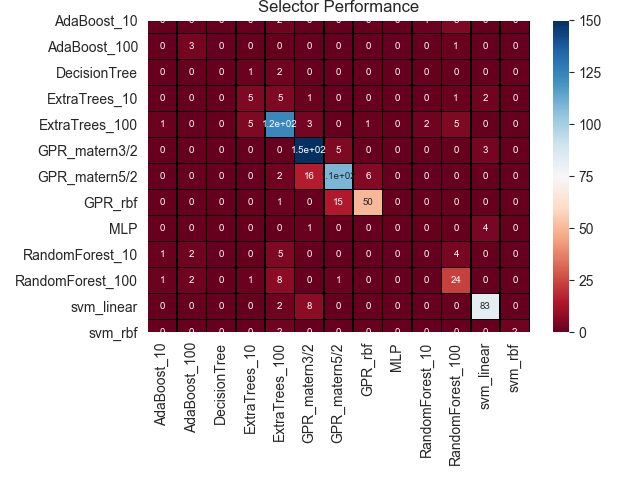

Text(0.5, 1, 'Selector Performance')

In [13]:
con_mat = metrics.confusion_matrix(test_targets, predicted_targets)
con_mat = pd.DataFrame(con_mat, index=selector.classes_, columns= selector.classes_)
sns.set_style("whitegrid")
sns.heatmap(con_mat,cmap="RdBu",annot=True,annot_kws={"size": 7},linewidths=0.5, linecolor='black')
plt.tight_layout()
plt.title('Selector Performance')

In [14]:
# For loss comparison
comparison_index = loss.index.intersection(predicted_targets.index)
loss_compare = loss.loc[comparison_index]
loss_prediction = pd.DataFrame(columns=['Prediction'], index=comparison_index, dtype=float)

In [15]:
for comp_id in comparison_index:
    loss_prediction['Prediction'].at[comp_id] = loss_compare[predicted_targets.loc[comp_id]].loc[comp_id]

In [16]:
loss_compare.sort_index(axis=1, inplace=True)
loss_compare = loss_compare.join(loss_prediction)

<IPython.core.display.Javascript object>


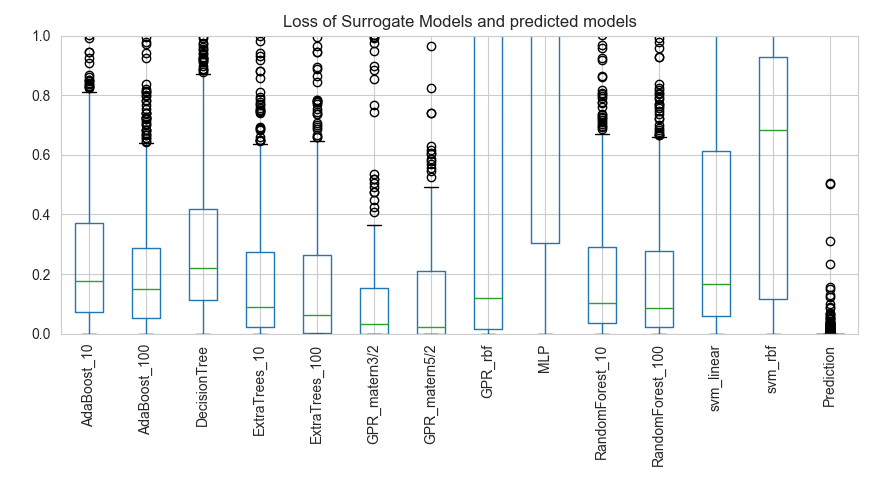

Prediction    0.023755
Name: 0.95, dtype: float64

In [17]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [18]:
# Direct Prediction with CV Values
loss_predictionCVmax = pd.DataFrame(columns=['CVmax'], index=comparison_index, dtype=float)
for comp_id in comparison_index:
    loss_predictionCVmax['CVmax'].at[comp_id] = loss_compare[cv_max_best.loc[comp_id]].loc[comp_id]

    
loss_predictionCVmean = pd.DataFrame(columns=['CVmean'], index=comparison_index, dtype=float)
for comp_id in comparison_index:
    loss_predictionCVmean['CVmean'].at[comp_id] = loss_compare[cv_mean_best.loc[comp_id]].loc[comp_id]

In [19]:
loss_compare = loss_compare.join(loss_predictionCVmax)
loss_compare = loss_compare.join(loss_predictionCVmean)

<IPython.core.display.Javascript object>


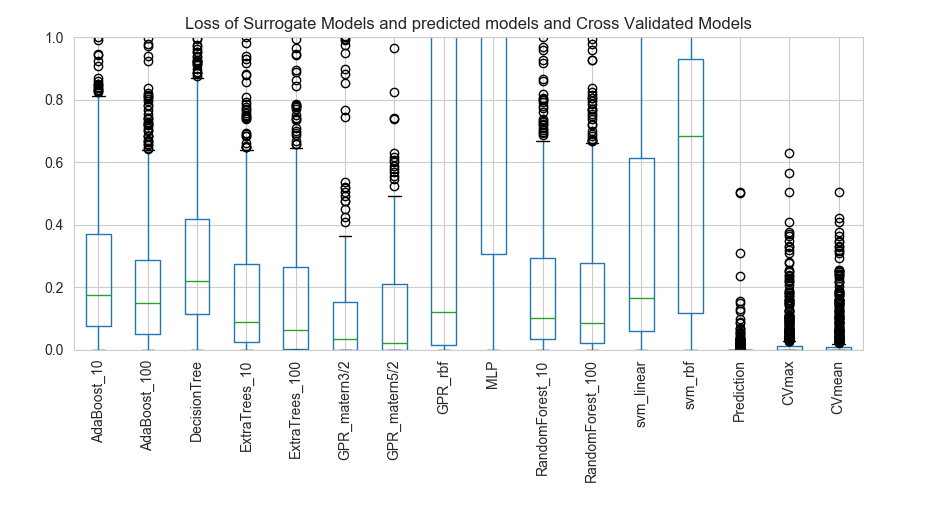

Prediction    0.023755
Name: 0.95, dtype: float64

In [20]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models and Cross Validated Models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

<IPython.core.display.Javascript object>


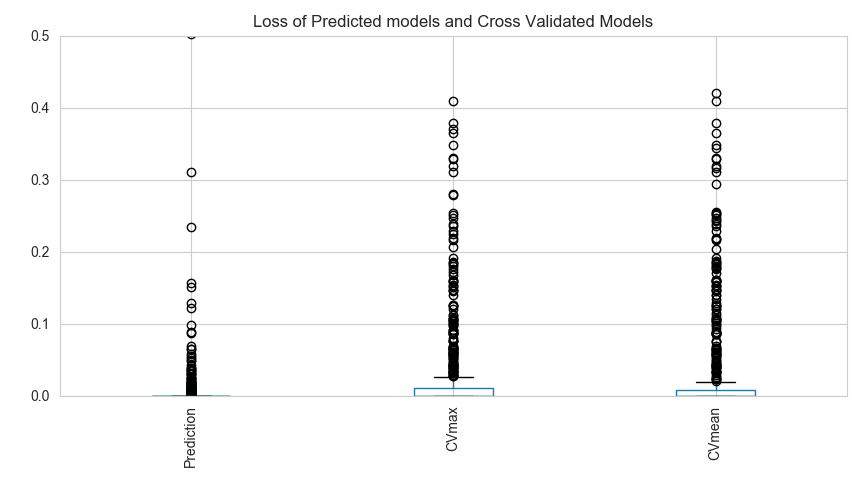

Prediction    0.023755
Name: 0.95, dtype: float64

In [21]:
loss_chart = loss_compare[['Prediction', 'CVmax', 'CVmean']].boxplot(rot=90)
loss_chart.set_title('Loss of Predicted models and Cross Validated Models')
loss_chart.set_ylim([0,0.5])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [22]:
loss_compare.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction,CVmax,CVmean
count,678.000000,678.000000,678.000000,678.000000,678.000000,6.780000e+02,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
mean,0.267651,0.224799,0.302030,0.195681,0.178618,6.018159e-01,0.982960,24.293345,4.314519,0.207701,0.194968,0.351956,0.610405,0.019004,0.147540,0.145627
std,0.270307,0.255321,0.271750,0.251321,0.253177,2.573390e+00,4.252900,97.385759,6.596503,0.257320,0.258997,0.414896,0.510567,0.345175,0.901348,0.917243
min,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.074661,0.051702,0.114603,0.024261,0.001628,1.947637e-08,0.000253,0.015373,0.305720,0.034643,0.021710,0.058474,0.116196,-0.000000,-0.000000,-0.000000
50%,0.175619,0.148656,0.219557,0.089963,0.062626,3.352598e-02,0.022215,0.120752,1.158290,0.103027,0.085145,0.166889,0.683561,-0.000000,-0.000000,-0.000000
75%,0.371510,0.287523,0.417105,0.273443,0.263242,1.537037e-01,0.209333,2.650666,4.898446,0.292362,0.278749,0.613253,0.929607,-0.000000,0.010611,0.008134
max,1.527172,1.488739,1.449932,1.418654,1.414969,5.685679e+01,56.863359,640.163801,41.310136,1.454521,1.462469,3.685188,2.613276,8.949397,10.331956,10.331956


## Saving the model

In [24]:
import pickle

with open('./results/selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

## Analysis of loss

In [51]:
# To get the problem characteristics out of the filename:

columns = {'ProblemName':0, 'num_var':1, 'num_samples':2, 'distribution':3}

characteristics = pd.DataFrame(index=loss_prediction.index, columns=columns)
for index in characteristics.index:
    for column in columns:
        characteristics[column][index] = index.split('.')[0].split('_')[columns[column]]
characteristics['num_var'] = characteristics['num_var'].astype(int)
characteristics['num_samples'] = characteristics['num_samples'].astype(int)

selector_performance = characteristics.join(loss_prediction)

selector_performance.head()

,ProblemName,num_var,num_samples,distribution,Prediction
WFG7_20_350_normal.csv,WFG7,20,350,normal,-0.0
DTLZ2_16_150_normal.csv,DTLZ2,16,150,normal,-0.0
DTLZ5_6_800_uniform.csv,DTLZ5,6,800,uniform,-0.0
WFG2_30_1200_uniform.csv,WFG2,30,1200,uniform,-0.0
WFG7_20_350_uniform.csv,WFG7,20,350,uniform,-0.0


<IPython.core.display.Javascript object>


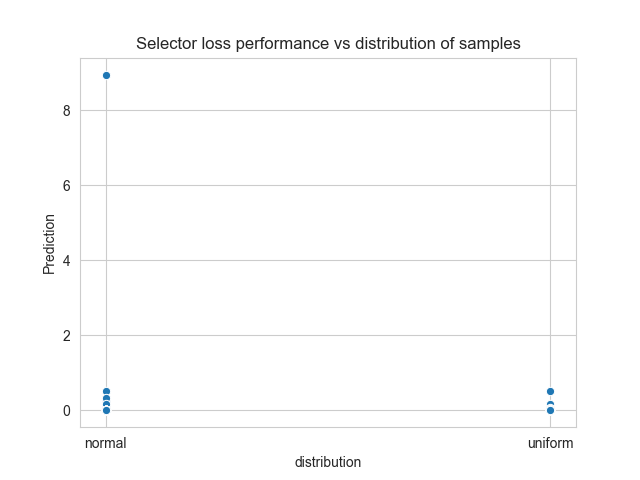

Text(0.5, 1.0, 'Selector loss performance vs distribution of samples')

In [60]:
sns.scatterplot(x='distribution', y='Prediction', data=selector_performance)
plt.title('Selector loss performance vs distribution of samples')

<IPython.core.display.Javascript object>


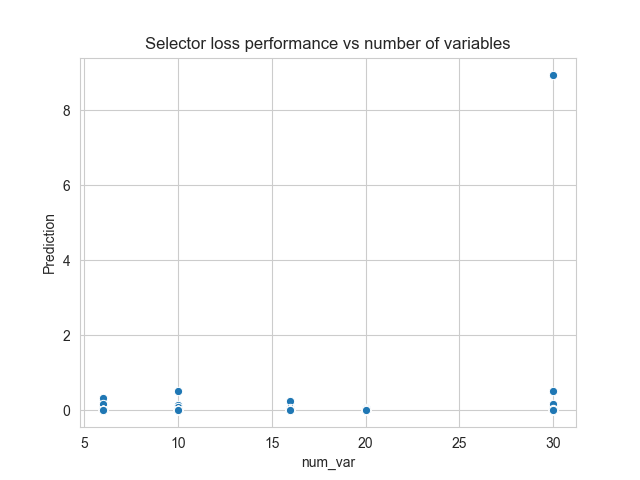

Text(0.5, 1.0, 'Selector loss performance vs number of variables')

In [61]:
sns.scatterplot(x='num_var', y='Prediction', data=selector_performance)
plt.title('Selector loss performance vs number of variables')

<IPython.core.display.Javascript object>


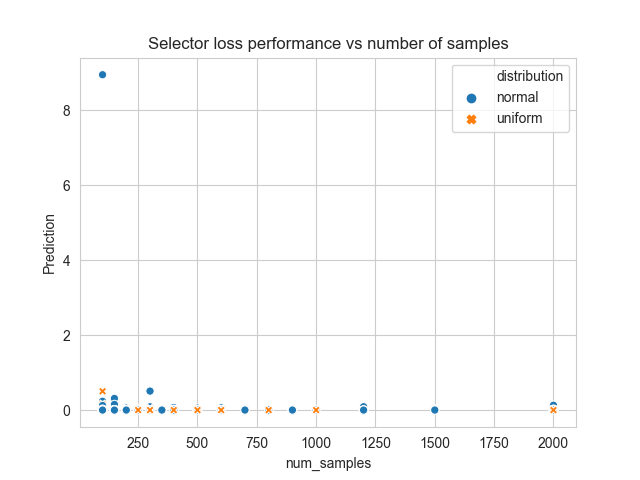

In [62]:
sns.scatterplot(x='num_samples', y='Prediction', hue='distribution', style='distribution', data=selector_performance)
plt.title('Selector loss performance vs number of samples')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


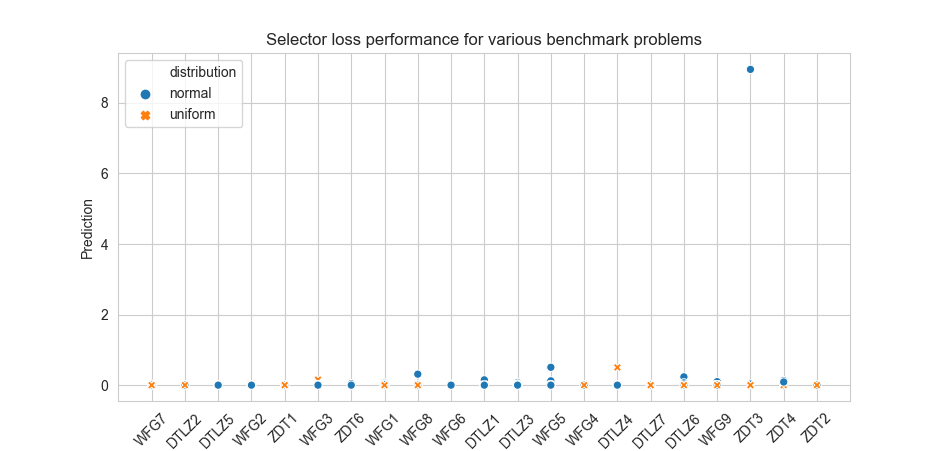

Text(0.5, 1.0, 'Selector loss performance for various benchmark problems')

In [66]:
sns.scatterplot(x='ProblemName', y='Prediction', hue='distribution', style='distribution', data=selector_performance)
#sns.boxplot(x='ProblemName', y='CVmean', data=CV_data[CV_data['distribution']=='uniform'])
#sns.catplot(x='ProblemName', y='CVmean',row='distribution', kind='box', data=CV_data)
plt.xticks(rotation=45)
plt.title('Selector loss performance for various benchmark problems')

<IPython.core.display.Javascript object>


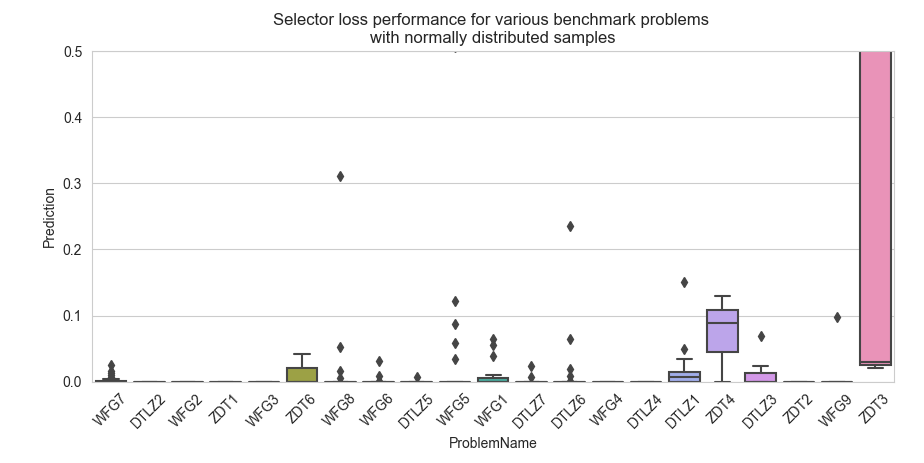

In [67]:
#sns.scatterplot(x='ProblemName', y='CVmean', hue='distribution', style='distribution', data=CV_data)
sns.boxplot(x='ProblemName', y='Prediction', data=selector_performance[selector_performance['distribution']=='normal'])
plt.xticks(rotation=45)
plt.ylim([0,0.5])
plt.title('Selector loss performance for various benchmark problems \nwith normally distributed samples')
plt.tight_layout()

## Feature Importances

In [25]:
importances = selector.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector.estimators_],
             axis=0)
feat_importance = pd.DataFrame(np.vstack((importances, std)), columns=features.columns, index=['mean', 'std'])

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


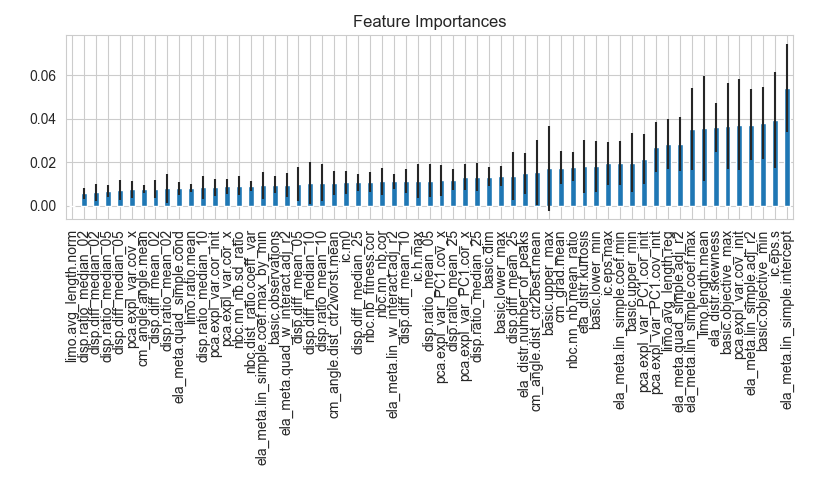

In [26]:
feat_importance.sort_index(by=['mean'], axis=1, inplace=True)
fig = feat_importance.loc['mean'].plot.bar(yerr=feat_importance.loc['std'])
plt.title('Feature Importances')
plt.tight_layout()

In [27]:
engineering_features = pd.read_csv("./features/engineering.csv", index_col=0)
engineering_features = engineering_features[features.columns]
engineering_features = engineering_features.dropna()

In [28]:
engineering_R2 = pd.read_csv('./surrogate_performance/engineeringR^2.csv', index_col=0)
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
engineering_loss = -engineering_R2.sub(engineering_R2.max(axis=1), axis=0)
engineering_targets = engineering_loss.idxmin(axis=1)
# Getting data that is avalable in both targets and features
features_available_for = engineering_targets.index.intersection(engineering_features.index)
engineering_targets = engineering_targets.loc[features_available_for]
engineering_loss = engineering_loss.loc[features_available_for]

<IPython.core.display.Javascript object>


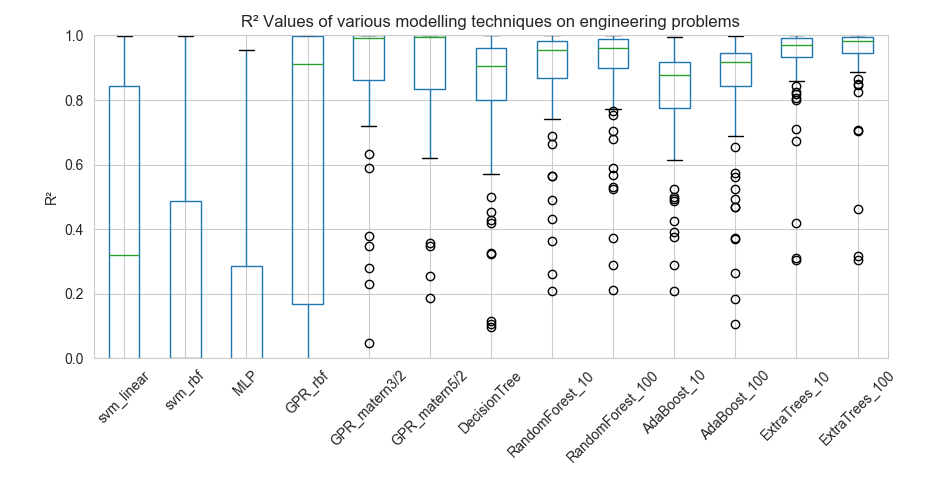

In [29]:
engineering_R2.plot.box(rot=45)
plt.ylim([0,1])
plt.ylabel('R²')
plt.title('R² Values of various modelling techniques on engineering problems')
plt.tight_layout()

In [30]:
selector = ExTC(n_estimators=10)
selector.fit(features.values, targets.values)
engineering_predictions = selector.predict(engineering_features)
engineering_predictions = pd.DataFrame(engineering_predictions, index=engineering_features.index, columns=['Prediction'])

In [31]:
metrics.confusion_matrix(engineering_targets, engineering_predictions)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 1,  0,  8,  0,  0,  0,  0,  3, 14,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  3,  4,  8,  0,  2,  3,  1],
       [ 0,  2,  1,  0,  0,  7,  0,  1,  7,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [32]:
engineering_loss_prediction = pd.DataFrame(columns=['Prediction'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_prediction['Prediction'].at[comp_id] = engineering_loss[engineering_predictions.loc[comp_id]].loc[comp_id]

In [33]:
engineering_loss.sort_index(axis=1, inplace=True)
engineering_loss = engineering_loss.join(engineering_loss_prediction)

## Cross Validation data

In [34]:
cv_scores_mean = pd.read_csv("./surrogate_performance/engineeringCV-score-mean.csv", index_col=0)
cv_scores_mean = cv_scores_mean.loc[features_available_for]
cv_scores_max = pd.read_csv("./surrogate_performance/engineeringCV-score-max.csv", index_col=0)
cv_scores_max = cv_scores_max.loc[features_available_for]

In [35]:
cv_mean_best = cv_scores_mean.idxmax(axis=1)
cv_max_best = cv_scores_max.idxmax(axis=1)

In [36]:
metrics.confusion_matrix(engineering_targets, cv_mean_best)

array([[ 0,  1,  0,  0,  0,  0],
       [ 0, 26,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  1,  2, 20,  3,  0],
       [ 0,  0,  0,  2, 16,  0],
       [ 0,  0,  2,  1,  0,  0]])

In [37]:
metrics.confusion_matrix(engineering_targets, cv_max_best)

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 26,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 22,  1,  0],
       [ 0,  0,  0,  0,  5, 13,  0],
       [ 0,  0,  0,  2,  1,  0,  0]])

In [38]:
engineering_loss_predictionCVmax = pd.DataFrame(columns=['PredictionCVmax'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_predictionCVmax['PredictionCVmax'].at[comp_id] = engineering_loss[cv_max_best.loc[comp_id]].loc[comp_id]

    
engineering_loss_predictionCVmean = pd.DataFrame(columns=['PredictionCVmean'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_predictionCVmean['PredictionCVmean'].at[comp_id] = engineering_loss[cv_mean_best.loc[comp_id]].loc[comp_id]

In [39]:
engineering_loss = engineering_loss.join(engineering_loss_predictionCVmax)
engineering_loss = engineering_loss.join(engineering_loss_predictionCVmean)

## Plots

<IPython.core.display.Javascript object>


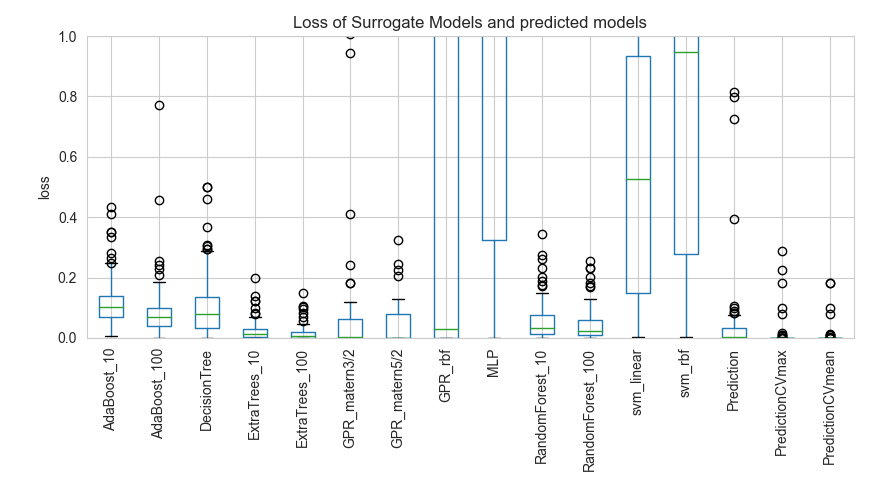

In [40]:
engg_loss_chart = engineering_loss.boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
plt.ylabel('loss')
engg_loss_chart.set_ylim([0,1])
plt.tight_layout()
engg_loss_chart

<IPython.core.display.Javascript object>


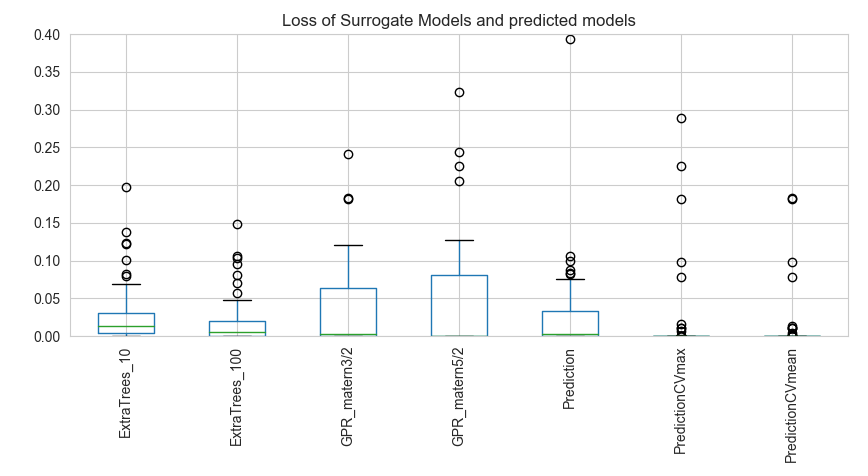

In [41]:
engg_loss_chart = engineering_loss[['ExtraTrees_10','ExtraTrees_100', 'GPR_matern3/2','GPR_matern5/2', 'Prediction', 'PredictionCVmax', 'PredictionCVmean']].boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
engg_loss_chart.set_ylim([0,0.4])
plt.tight_layout()
engg_loss_chart

In [42]:
engineering_loss.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction,PredictionCVmax,PredictionCVmean
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.119753,0.100426,0.111450,0.026402,0.016720,0.151598,0.176945,32.971680,66.272585,0.058712,0.048652,0.531101,0.703219,0.051079,0.011911,0.007711
std,0.095361,0.152892,0.116977,0.036064,0.028565,0.406823,0.490960,111.351412,220.510202,0.071614,0.060653,0.398577,0.436696,0.156069,0.047667,0.032145
min,0.005125,0.001085,0.000036,-0.000000,-0.000000,0.000002,-0.000000,-0.000000,-0.000000,0.000016,0.000010,0.002114,0.002207,-0.000000,-0.000000,-0.000000
25%,0.067919,0.039794,0.034042,0.003758,-0.000000,0.000107,-0.000000,0.000031,0.323454,0.013309,0.009045,0.149653,0.279390,0.000002,-0.000000,-0.000000
50%,0.101976,0.067813,0.079759,0.013654,0.005676,0.003260,0.000050,0.028301,3.723865,0.033138,0.024081,0.525263,0.948181,0.002283,-0.000000,-0.000000
75%,0.140208,0.099816,0.136860,0.030999,0.019397,0.063207,0.080757,1.547610,26.708943,0.074922,0.060918,0.932190,1.038348,0.032840,-0.000000,-0.000000
max,0.432549,1.053990,0.501111,0.197298,0.148233,2.214465,2.702947,413.478576,1259.316729,0.345750,0.256170,1.237660,1.306356,0.815406,0.288367,0.183104


In [43]:
engineering_loss.median()

AdaBoost_10         0.101976
AdaBoost_100        0.067813
DecisionTree        0.079759
ExtraTrees_10       0.013654
ExtraTrees_100      0.005676
GPR_matern3/2       0.003260
GPR_matern5/2       0.000050
GPR_rbf             0.028301
MLP                 3.723865
RandomForest_10     0.033138
RandomForest_100    0.024081
svm_linear          0.525263
svm_rbf             0.948181
Prediction          0.002283
PredictionCVmax     0.000000
PredictionCVmean    0.000000
dtype: float64